In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [2]:
# Generate data
def gen_data():
    x = np.linspace(0, 100, 501)
    y = np.sin(x)
    df = pd.DataFrame(data=y, index=x, columns=['Sine'])
    
    return df

In [3]:
def train_test_split(df, test_perct=0.1, scale=False):
    test_point = np.round(len(df) * test_perct)
    test_index = int(len(df) - test_point)
    train = df.iloc[:test_index]
    test = df.iloc[test_index:]
    
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(train)
        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)
        
        return scaled_train, scaled_test, scaler
    else:
        return train, test

In [4]:
class make_generator:
     
    def __init__(self, gen_name, val_split=0.1):
        if (gen_name == 'train_val') | (gen_name == 'test'):
            self.gen_name = gen_name
            self.val_split = val_split
        else:
            print("Not a valid Generator class name")
        
    def generator(self, data, length, batch_size=1):
        gen_name = self.gen_name
        val_split = self.val_split
        
        if gen_name == 'train_val':
            val_point = np.round(len(data) * val_split)
            val_index = int(len(data) - val_point)
            train_data = data[:val_index]
            val_data = data[val_index:]
            
            if len(val_data) <= length:
                print("Length is equal to or less than validation data length. Please reduce Length or increase validation split")
            else:
                train_generator = TimeseriesGenerator(train_data, train_data, length=length, batch_size=batch_size)
                val_generator = TimeseriesGenerator(val_data, val_data, length=length, batch_size=batch_size)
                return train_generator, val_generator
        else:
            test_generator = TimeseriesGenerator(data, data, length=length, batch_size=batch_size)
            return test_generator

In [5]:
# Prepare GPU
def prep_devices():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')
    
    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [6]:
# Build model
def model_func(length, n_features, clear_session=True):
    if clear_session:
        backend.clear_session()
            
    model = Sequential()
    
    model.add(SimpleRNN(50, input_shape=(length, n_features)))
    model.add(Dense(1))
    
    model.summary()
    
    return model

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
prep_devices()

Physical GPUs: 1	Logical GPUs: 1
Physical CPUs: 1	Logical CPUs: 1


In [10]:
actual_data = gen_data()
train_set, test_set, scaler = train_test_split(df=actual_data, scale=True)

In [14]:
length = 45
n_features = 1

train_gen, val_gen = make_generator(gen_name='train_val', val_split=0.15).generator(data=train_set, length=length)
test_gen = make_generator(gen_name='test').generator(data=test_set, length=length)

In [15]:
# Fit model
model = model_func(length=length, n_features=n_features)
model.compile(loss='mse', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
338/338 [==============================] - 7s 22ms/step - loss: 0.0268 - val_loss: 1.2042e-04
Epoch 2/20
338/338 [==============================] - 7s 21ms/step - loss: 1.1575e-04 - val_loss: 5.5955e-05
Epoch 3/20
338/338 [==============================] - 7s 22ms/step - loss: 1.0696e-04 - val_loss: 1.0698e-04
Epoch 4/20
338/338 [==============================] - 7s 21ms/step - loss: 6.2304e-05 - val_loss: 6.1937e-05
Epoch 5/20
338/338 [==============================] - 7s 21ms/step - loss: 0.0019 - 

<AxesSubplot:>

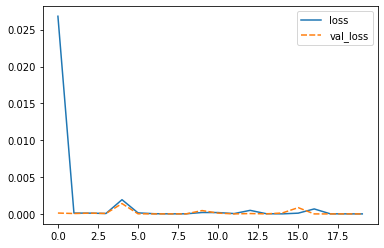

In [16]:
losses = pd.DataFrame(model.history.history)
sns.lineplot(data=losses)

In [17]:
# Create moving window of evaluation batches
test_predictions = []
first_eval_batch = train_set[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for index in range(len(test_set)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [18]:
true = pd.DataFrame(data=test_set.flatten())
pred = pd.DataFrame(data=scaler.inverse_transform(test_predictions).flatten())

In [19]:
result_df = pd.concat([true, pred], axis=1)

In [20]:
result_df.columns = ['True', 'Pred']

<AxesSubplot:>

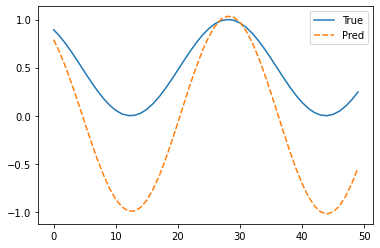

In [21]:
# With 40 train and 0.15 as validation
sns.lineplot(data=result_df)

<AxesSubplot:>

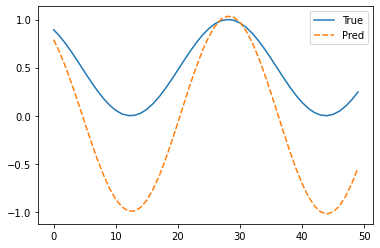

In [22]:
# With 45 train and 0.15 as validation
sns.lineplot(data=result_df)